In [18]:
# random forest

In [19]:
import numpy as np
import pandas as pd
import os
import pickle
import re
import warnings
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
import sklearn.tree as tree

In [20]:
os.getcwd()
from thon.Choose import choose_features
#data = choose_features("data/out/features.csv", cv_range = (0, 30), save = False)

C:\Users\keato\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:394: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\keato\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
C:\Users\keato\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.584e+03, tolerance: 2.274e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solver

Alpha estimate: {'model__alpha': 5.0}
15 features selected 



In [21]:
data = pd.read_csv("data/out/features.csv")

In [22]:
# Training data
X, y = data.drop(columns = ['n']), data['n']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, shuffle = False)

In [23]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor())
])

In [24]:
search = GridSearchCV(pipeline,
                      {'model__n_estimators':np.arange(50, 301, 50)},                      
                      cv = 5,
                      scoring = 'neg_mean_squared_error',
                      verbose = 1)

In [25]:
search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', RandomForestRegressor())]),
             param_grid={'model__n_estimators': array([ 50, 100, 150, 200, 250, 300])},
             scoring='neg_mean_squared_error', verbose=1)

In [26]:
search.best_params_.get("model__n_estimators")

300

In [27]:
# Training data

# Train the model
randomforestmodel = RandomForestRegressor(n_estimators = search.best_params_.get("model__n_estimators"), random_state = 0, max_features = "sqrt")
randomforestmodel.fit(X_train, y_train)

# Store the fitted values as a time series with the same time index as
# the training data
train_pred = pd.Series(randomforestmodel.predict(X_train), index=X_train.index)
test_pred = pd.Series(randomforestmodel.predict(X_test), index=X_test.index)

In [28]:
train_pred = train_pred.sort_index()
y_train = y_train.sort_index()
test_pred = test_pred.sort_index()
y_test = y_test.sort_index()

252.5261814009661


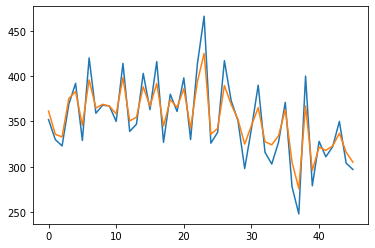

In [29]:
def plot_eval(prediction, actual):
    plt.plot(actual)
    plt.plot(prediction)
    print(mean_squared_error(prediction, actual))

plot_eval(train_pred, y_train)

11330.999991666666


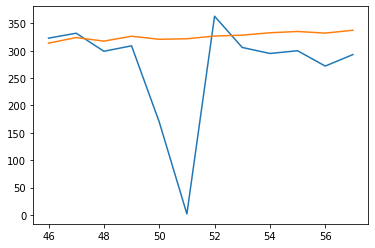

In [30]:
plot_eval(test_pred, y_test)

In [31]:
# feature names used in model
def get_tree_importance(model, cols, save = False):
    imp = pd.DataFrame(model.feature_importances_,
                       index = cols,
                       columns = ['importance'])
    if save == True:
        imp.to_csv("data/out/treefeatures.csv")
    else:
        return imp

imp = get_tree_importance(randomforestmodel, X_train.columns)
imp.sort_values("importance", ascending = False)

,importance
month,0.122849
10yinf_lag12,0.116531
XOM_lag6,0.100820
AN_v_lag3,0.096081
GM_v_lag9,0.090691
g_new_cars_lag6,0.087501
GM_lag9,0.075991
altsales_lag12,0.058943
new_units_lag3,0.058405
g_best_new_cars_lag6,0.048066


In [32]:
def save_model(mod, filename):
    with open("models/" + filename, 'wb') as file:
        pickle.dump(mod, file)

save_model(randomforestmodel, "randomforestmodel.pkl")

In [161]:
# Currently naming cols with incorrect lag for model ingestion
def churn(feature_importance_df, complete_path = "./data/out/complete.csv", ahead = 3):
    
    complete = pd.read_csv(complete_path)
    
    impidx = feature_importance_df[feature_importance_df["importance"] > 0].index
    names = []
    for i in list(impidx):
        if i not in ["month", "bin"]:
            names.append(i.split("_lag")[0] + "_lag" + str(pd.to_numeric(re.sub(r".*_lag", "", i)) - ahead))
        
    important = complete.filter(names) #### AHHHH BAD
    important.columns = (x for x in list(impidx) if x not in ["month", "bin"]) #### AHHHHH BAD
    important = important.tail(ahead)
    important.set_axis(np.arange(ahead), inplace = True)
    
    warnings.warn("Features are named incorrectly, they are led 3 months ahead of their label")
    
    # add unimportant names back with empty values
    unimpidx = list(set(impidx).difference(impidx))
    dummy = pd.DataFrame(0, index=np.arange(len(important)), columns=unimpidx).tail(ahead)
    dummy.set_axis(np.arange(ahead), inplace = True)
    
    if ("bin" in list(impidx)) & ("month" in list(impidx)):
        supp = pd.read_csv("data/out/suppl.csv")
        supp.set_axis(list(dummy.index), inplace = True)
        out = pd.concat([important, dummy, supp], axis = 1)
    
    elif "bin" in list(impidx):
        supp = pd.read_csv("data/out/suppl.csv").filter("bin")
        supp.set_axis(list(dummy.index), inplace = True)
        out = pd.concat([important, dummy, supp], axis = 1).tail(ahead)

    elif "month" in list(impidx):
        supp = pd.read_csv("data/out/suppl.csv").filter("month")
        supp.set_axis(list(dummy.index), inplace = True)
        out = pd.concat([important, dummy, supp], axis = 1).tail(ahead)
        
    else: 
        out = pd.concat([important, dummy]).tail(ahead)

    # reorder cols
    out = out[list(feature_importance_df.index)]

    return(out)

newdata = churn(imp)

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Features are named incorrectly, they are led 3 months ahead of their label


C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Features are named incorrectly, they are led 3 months ahead of their label
  # This is added back by InteractiveShellApp.init_path()


array([0, 1, 2])

In [162]:
# predict
randomforestmodel.predict(newdata)

array([331.84333333, 356.03      , 348.96      ])

In [ ]:
pd.concat([imp.tail(3), suppl], axis = 0)